In [1]:
elastic_rods_dir = '../../../../elastic_rods/python/'
weaving_dir = '../../../'
import os
import os.path as osp
import sys; sys.path.append(elastic_rods_dir); sys.path.append(weaving_dir)
import numpy as np, elastic_rods, linkage_vis
import numpy.linalg as la
from bending_validation import suppress_stdout as so
import matplotlib.pyplot as plt
from elastic_rods import EnergyType, InterleavingType

# weaving
import analysis_helper, ribbon_linkage_helper, mesh_vis, linkage_utils, compute_curve_from_curvature, pipeline_helper, importlib
importlib.reload(analysis_helper)
importlib.reload(ribbon_linkage_helper)
importlib.reload(mesh_vis)
importlib.reload(linkage_utils)
importlib.reload(compute_curve_from_curvature)
importlib.reload(pipeline_helper)
from analysis_helper import (compare_turning_angle,
                            is_on_sphere, 
                            get_distance_to_center_scalar_field, 
                            plot_curvatures, 
                            get_curvature_scalar_field,
                            construct_elastic_rod_loop_from_rod_segments, 
                            concatenate_rod_properties_from_rod_segments, 
                            compute_min_distance_rigid_transformation)
from ribbon_linkage_helper import (update_rest_curvature, 
                                   set_ribbon_linkage,
                                   export_linkage_geometry_to_obj,
                                   write_linkage_ribbon_output_florin)

from compute_curve_from_curvature import (match_geo_curvature_and_edge_len, get_all_curve_pattern)
from linkage_utils import order_segments_by_ribbons, get_turning_angle_and_length_from_ordered_rods

from pipeline_helper import (initialize_linkage, get_normal_deviation, set_joint_vector_field, stage_1_optimization, initialize_stage_2_optimizer, stage_2_optimization, InputOrganizer, write_all_output, set_surface_view_options, get_structure_analysis_view, contact_optimization, get_double_side_view, show_selected_joints, highlight_rod_and_joint)
import vis.fields
import matplotlib.cm as cm
import time

In [2]:
import parallelism
parallelism.set_max_num_tbb_threads(24)
parallelism.set_hessian_assembly_num_threads(8)
parallelism.set_gradient_assembly_num_threads(8)

In [3]:
rod_length = 0.05979705114046488
width = rod_length / 20 * 5
thickness = width / 5 * 0.35
print(width, thickness)
io = InputOrganizer('bird_close_beak_1', thickness, width, weaving_dir)

0.01494926278511622 0.0010464483949581352


In [4]:
import py_newton_optimizer
# Optimization parameters.
OPTS = py_newton_optimizer.NewtonOptimizerOptions()
OPTS.gradTol = 1e-8
OPTS.verbose = 1;
OPTS.beta = 1e-8
OPTS.niter = 200
OPTS.verboseNonPosDef = False
rw = 0.01
sw = 10
drw = 0.01
dsw = 0.1

In [5]:
import pickle 
import gzip

In [6]:
curved_linkage = pickle.load(gzip.open('{}_stage_2_20201228.pkl.gz'.format(io.MODEL_NAME), 'r'))
curved_linkage_view = linkage_vis.LinkageViewerWithSurface(curved_linkage, io.SURFACE_PATH)
curved_save_tgt_joint_pos = curved_linkage.jointPositions();
set_surface_view_options(curved_linkage_view, linkage_color='lightgreen')
curved_linkage_view.show()

Renderer(camera=PerspectiveCamera(children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), quaternion=(…

In [7]:
# curved_linkage.setDesignParameters(np.load('../../nature_paper_experiments/figure_1/results/bird_close_beak_1/bird_close_beak_1_dof.npy')[curved_linkage.numDoF():])

In [8]:
curved_linkage.attraction_weight = 1e-5

In [9]:
def eqm_callback(prob, i):
#     curved_linkage_view.update()
    pass

In [10]:
elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS)

0	1.88173e-06	3.3065e-09	3.3065e-09	0	0


In [11]:
# import pickle
# import gzip
# pickle.dump(curved_linkage, gzip.open('{}_stage_2_20201228.pkl.gz'.format(io.MODEL_NAME), 'w'))

In [12]:
def get_opposite_joint_type(curr_type):
    if curr_type == curved_linkage.joint(0).Type.A_OVER_B:
        return curved_linkage.joint(0).Type.B_OVER_A
    return curved_linkage.joint(0).Type.A_OVER_B
import structural_analysis

../../../../elastic_rods/python/structural_analysis.py:213: RuntimeWarning: invalid value encountered in true_divide
  coefficientOfFriction = cfm[:, 1] / (-separationForce)
/Users/yren/Library/Python/3.7/lib/python/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/yren/Library/Python/3.7/lib/python/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Coefficient of Friction Percentiles 50, 75, 90:  nan nan nan


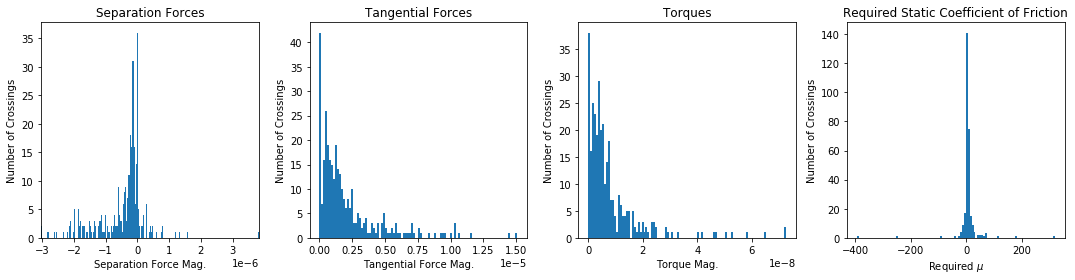

In [13]:
structure_view = get_structure_analysis_view(curved_linkage)
structure_view.show()

In [86]:
optimizer = initialize_stage_2_optimizer(curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, rw, sw, inner_gradTol = 1e-6)

In [ ]:
optimizer, contact_opt_iterateData = contact_optimization(optimizer, curved_linkage, curved_linkage_view, minRestLen=-1, contact_weight = 5e8, normalWeight = 20, torqueWeight = 0, maxIter=2000, normalActivationThreshold=-1e-7)

In [14]:
cfm = structural_analysis.weavingCrossingForceMagnitudes(curved_linkage, True)
if np.sum(cfm[:, 0]>0) > 0:
    print("Flipping crossing: ", np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):])
    for i in np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):]:
        curved_linkage.joint(i).type = get_opposite_joint_type(curved_linkage.joint(i).type)
    elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS)
    curved_linkage_view.update()

Flipping crossing:  [106 273  47  13  79 165 226  90 147 198   5 159 158 234 151 274 275 196
 260  60 283 103 213 101 118 131 205 217  24 176 135  44 303  97  46  69]
0	4.62101e-05	0.0352524	0.0352524	1	1
1	1.15688e-05	0.0202918	0.0202918	1	1
2	7.2682e-06	0.00570505	0.00570505	1	1
3	5.23476e-06	0.00108609	0.00108609	1	0
4	2.77118e-06	0.00395289	0.00395289	1	1
5	2.19509e-06	0.000184385	0.000184385	1	0
6	1.96027e-06	0.000247523	0.000247523	1	0
7	1.94479e-06	0.000263387	0.000263387	0.25	0
8	1.94359e-06	0.000324957	0.000324957	1	0
9	1.93994e-06	5.46465e-05	5.46465e-05	1	1
10	1.93987e-06	1.74403e-06	1.74403e-06	1	1
11	1.93985e-06	9.08828e-07	9.08828e-07	1	1
12	1.93984e-06	6.05001e-07	6.05001e-07	1	1
13	1.93983e-06	4.33687e-07	4.33687e-07	1	1
14	1.93981e-06	3.33226e-07	3.33226e-07	1	1
15	1.93979e-06	2.80473e-07	2.80473e-07	1	1
16	1.93976e-06	2.63982e-07	2.63982e-07	1	1
17	1.9397e-06	3.33715e-07	3.33715e-07	1	1
18	1.93961e-06	1.13567e-06	1.13567e-06	1	1
19	1.93942e-06	5.39893e-06	5.39893e-06	

Coefficient of Friction Percentiles 50, 75, 90:  nan nan nan


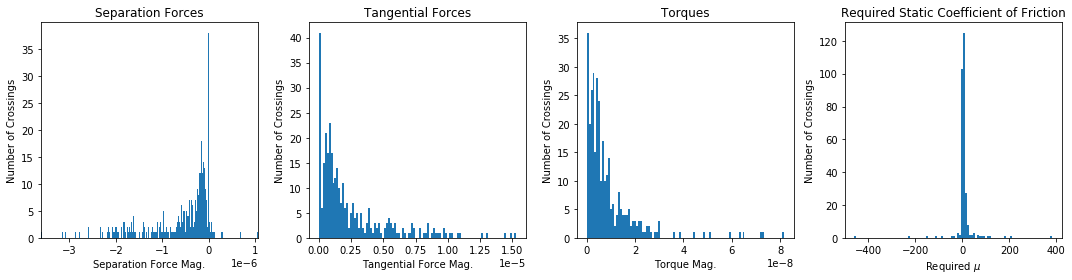

In [15]:
second_structure_view = get_structure_analysis_view(curved_linkage)
second_structure_view.show()

In [16]:
cfm = structural_analysis.weavingCrossingForceMagnitudes(curved_linkage, True)
if np.sum(cfm[:, 0]>0) > 0:
    print("Flipping crossing: ", np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):])
    for i in np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):]:
        curved_linkage.joint(i).type = get_opposite_joint_type(curved_linkage.joint(i).type)
    elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS)
    curved_linkage_view.update()

Flipping crossing:  [319 235   4 117  89 147 223 106  51 272 273 315 242]
0	1.96822e-05	0.0215375	0.0215375	0.5	1
1	1.58206e-05	0.0662308	0.0662308	1	1
2	7.98291e-06	0.00537789	0.00537789	1	1
3	6.58965e-06	0.00268666	0.00268666	1	1
4	5.50679e-06	0.00173927	0.00173927	1	1
5	4.63255e-06	0.00112849	0.00112849	1	1
6	3.94517e-06	0.000739874	0.000739874	1	1
7	3.41095e-06	0.000500369	0.000500369	1	1
8	3.00036e-06	0.000344957	0.000344957	1	1
9	2.69048e-06	0.000241067	0.000241067	1	1
10	2.46034e-06	0.000176792	0.000176792	1	1
11	2.29213e-06	0.000135614	0.000135614	1	1
12	2.1716e-06	0.000109602	0.000109602	1	1
13	2.0873e-06	9.54836e-05	9.54836e-05	1	1
14	2.02999e-06	8.8908e-05	8.8908e-05	1	1
15	1.99258e-06	9.39322e-05	9.39322e-05	1	1
16	1.96989e-06	9.16697e-05	9.16697e-05	1	1
17	1.95745e-06	6.98471e-05	6.98471e-05	1	1
18	1.95106e-06	3.41021e-05	3.41021e-05	1	1
19	1.94778e-06	1.24656e-05	1.24656e-05	1	1
20	1.94593e-06	1.31267e-05	1.31267e-05	0.0078125	0
21	1.94586e-06	3.31251e-05	3.31251e-05	0.25

Coefficient of Friction Percentiles 50, 75, 90:  nan nan nan


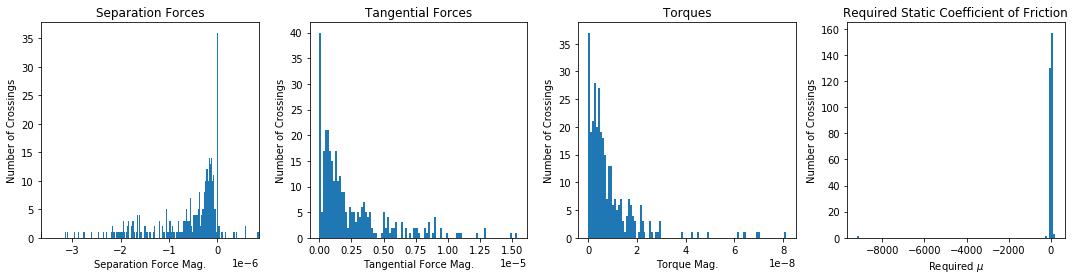

In [17]:
third_structure_view = get_structure_analysis_view(curved_linkage)
third_structure_view.show()

In [18]:
cfm = structural_analysis.weavingCrossingForceMagnitudes(curved_linkage, True)
if np.sum(cfm[:, 0]>0) > 0:
    print("Flipping crossing: ", np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):])
    for i in np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):]:
        curved_linkage.joint(i).type = get_opposite_joint_type(curved_linkage.joint(i).type)
    elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS)
    curved_linkage_view.update()

Flipping crossing:  [275   4 319 273  68  69  29 106  66 306  71  67 271 242]
0	1.94255e-05	0.0211414	0.0211414	1	1
1	1.38239e-05	0.090482	0.090482	1	1
2	5.35693e-06	0.0126024	0.0126024	1	1
3	4.82779e-06	0.00152052	0.00152052	1	1
4	4.44621e-06	0.0010836	0.0010836	1	1
5	4.03287e-06	0.000796349	0.000796349	0.5	0
6	3.75909e-06	0.0104931	0.0104931	1	1
7	2.81379e-06	0.000740755	0.000740755	1	1
8	2.60301e-06	0.000430034	0.000430034	1	1
9	2.43088e-06	0.000194245	0.000194245	1	1
10	2.28443e-06	0.000180976	0.000180976	0.5	0
11	2.11688e-06	0.00412871	0.00412871	1	1
12	2.04565e-06	0.000308329	0.000308329	1	0
13	1.96027e-06	0.00186752	0.00186752	1	1
14	1.947e-06	2.50201e-05	2.50201e-05	1	0
15	1.94234e-06	0.000302938	0.000302938	0.5	0
16	1.93905e-06	0.000347156	0.000347156	1	0
17	1.93813e-06	0.000510113	0.000510113	1	1
18	1.93612e-06	7.11274e-06	7.11274e-06	1	0
19	1.93525e-06	0.000169641	0.000169641	1	0
20	1.93378e-06	2.53909e-05	2.53909e-05	0.0625	0
21	1.93371e-06	5.60243e-05	5.60243e-05	1	0
22	1.

Coefficient of Friction Percentiles 50, 75, 90:  nan nan nan


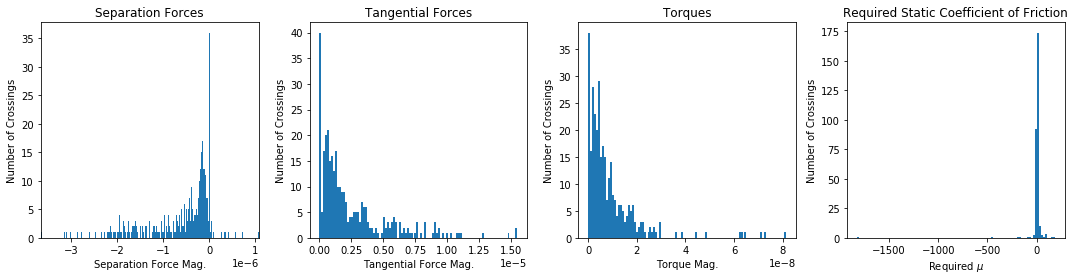

In [19]:
fourth_structure_view = get_structure_analysis_view(curved_linkage)
fourth_structure_view.show()

In [20]:
cfm = structural_analysis.weavingCrossingForceMagnitudes(curved_linkage, True)
if np.sum(cfm[:, 0]>0) > 0:
    print("Flipping crossing: ", np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):])
    for i in np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):]:
        curved_linkage.joint(i).type = get_opposite_joint_type(curved_linkage.joint(i).type)
    elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS)
    curved_linkage_view.update()

Flipping crossing:  [322 275   4 242  70 273 315 106  67  68  52  69 102]
0	1.83655e-05	0.0201615	0.0201615	0.5	1
1	1.19682e-05	0.0357586	0.0357586	1	1
2	5.93165e-06	0.0049874	0.0049874	1	1
3	4.64591e-06	0.00135833	0.00135833	1	1
4	3.82099e-06	0.000814934	0.000814934	1	1
5	3.24416e-06	0.000511033	0.000511033	1	1
6	2.82769e-06	0.000339367	0.000339367	1	0
7	2.37548e-06	0.00242031	0.00242031	1	1
8	2.08787e-06	0.000107741	0.000107741	1	0
9	1.95926e-06	0.000491319	0.000491319	1	1
10	1.9513e-06	8.56808e-06	8.56808e-06	0.25	0
11	1.94801e-06	0.000148206	0.000148206	1	0
12	1.94319e-06	0.000163737	0.000163737	0.5	0
13	1.9422e-06	0.000362586	0.000362586	1	0
14	1.93796e-06	0.000195066	0.000195066	0.5	0
15	1.93726e-06	0.000255638	0.000255638	1	0
16	1.93483e-06	0.000104201	0.000104201	1	0
17	1.93404e-06	0.00011664	0.00011664	0.5	0
18	1.93367e-06	9.41588e-05	9.41588e-05	1	0
19	1.93275e-06	2.4587e-05	2.4587e-05	0.25	0
20	1.93258e-06	3.65252e-05	3.65252e-05	1	0
21	1.93229e-06	4.75526e-05	4.75526e-05	0.

Coefficient of Friction Percentiles 50, 75, 90:  nan nan nan


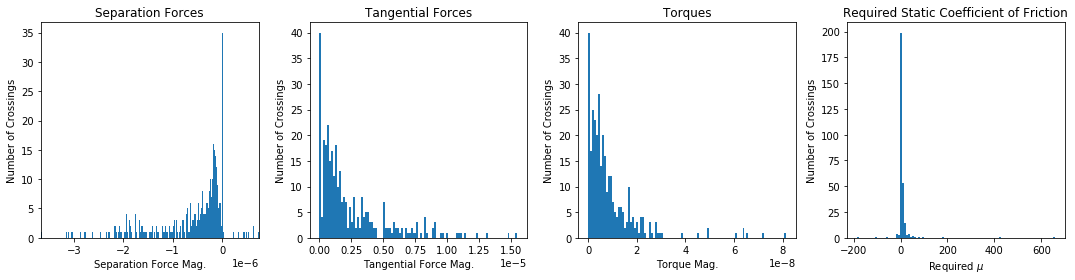

In [21]:
fifth_structure_view = get_structure_analysis_view(curved_linkage)
fifth_structure_view.show()

In [31]:
optimizer = initialize_stage_2_optimizer(curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, rw, sw, inner_gradTol = 1e-6)

In [32]:
optimizer, contact_opt_iterateData = contact_optimization(optimizer, curved_linkage, curved_linkage_view, minRestLen=-1, contact_weight = 5e6, normalWeight = 10, torqueWeight = 0, maxIter=2000, normalActivationThreshold=-1e-7)